<a href="https://colab.research.google.com/github/tbeucler/2022_ML_Earth_Env_Sci/blob/main/Lab_Notebooks/S2_1_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_This notebook will be used in the lab session for week 2 of the course, covers Chapters 3 of Géron, and builds on the [notebooks made available on _Github_](https://github.com/ageron/handson-ml2).

Need a reminder of last week's labs? Click [_here_](https://github.com/tbeucler/2022_ML_Earth_Env_Sci/blob/main/Lab_Notebooks/Week_1_Basics_of_Python.ipynb) to go to notebook for week 1 of the course.

##**Chapter 3 – Classification**

<table align="left">
  <td align=middle>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/03_classification.ipynb"> Open the original notebook <br><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

You don't need to worry about understanding everything that is written in this section.

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
rnd_seed = 42
rnd_gen = np.random.default_rng(rnd_seed)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)



We need to load the MNIST dataset from OpenML - we won't be loading it as a Pandas dataframe, but will instead use the Dictionary / ndrray representation.

In [ ]:
#Load the mnist dataset
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

X = mnist['data']
y = mnist['target'].astype(np.uint8)

Originally, Géron uses the entire MNIST dataset, which can take too long when training several models. As a result, we will generate and use a smaller set of data, taking care to balance it.

In [ ]:
# Generating a smaller balanced dataset for faster computation speed

# Per digit sample size
balanced_size = 1000

# Placeholder Vars
bal_X = None
bal_y = None

# Looping through digit types
for digit in np.arange(0,10):
  # find indices where target is digit of interest
  y_idxs = y==digit
  print(f'{digit} has {y_idxs.sum()} instances in the dataset')
  
  # rnd_gen.choice chooses n = balanced_size indices from the set of digits 
  # available. Since we know the truth is an array with the same number of rows
  # as the subset, full of the current digit 
  X_subset = X[y_idxs][rnd_gen.choice(np.arange(y_idxs.sum()),(balanced_size,))]
  y_subset = np.full(X_subset.shape[0],digit)

  if type(bal_X) == type(None):
    bal_X = X_subset
    bal_y = y_subset
  else:
    bal_X = np.vstack([bal_X, X_subset])
    bal_y = np.hstack((bal_y,y_subset))

# Shuffling the dataset
shuffler = rnd_gen.permutation(len(bal_X))
bal_X = bal_X[shuffler]
bal_y = bal_y[shuffler]

In [ ]:
# Splitting the dataset into train and test
from sklearn.model_selection import train_test_split

# set % of data to be used for testing
test_size=.10

X_train, X_test, y_train, y_test = train_test_split(bal_X, 
                                                    bal_y, 
                                                    test_size = test_size, 
                                                    random_state = rnd_seed)

In [ ]:
# Test that the label and image match. We're using np.random instead of our 
# rnd_gen since we don't want the runs of this snippet to vary the results in
# other snippets :) Run this as many times as you want!
test = np.random.randint(0,len(bal_X))
plt.imshow(bal_X[test].reshape((28,28)), cmap='Greys')
print(f'The image should be of a(n) {bal_y[test]}')

# Exercises

## 3.1) An MNIST Classifier With 97% Accuracy

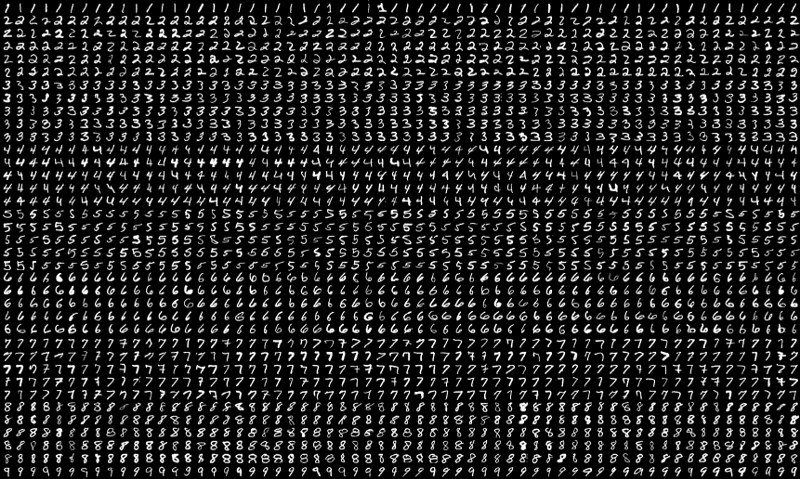

**Caption**: So many digits! 🔢 Can you classify them all?

For this exercise, we will look for the model with the best performance using Scikit's [`Grid Search`](https://duckduckgo.com/?q=gridsearchCV), which performs a ["round robin"](https://en.wikipedia.org/wiki/Round-robin_tournament) search on a set of possible hyperparameters to find the model with the best performance.

Search for Scikit's [`K-neighbors Classifier`](https://duckduckgo.com/?q=scikit+kneighbors) to find the documentation page. You will find a list of parameters that users can use when making the classifier.

**Questions (hints below):**

1. Define a list of dictionaries with the set of hyperparameters that are to be tested: 
<table align='middle'>
  <tr>
    <th> Hyper-Parameter</th>
    <th colspan="5" scope="colgroup">Values to Test</th>
  </tr>
  <tr>
    <td scope="col" align='middle'>Weights</td>
    <td scope="col" colspan="2" align='middle'><i>uniform</i></td>
    <td scope="col" colspan="2" align='middle'><i>distance</i></td>
  </tr>
    <tr>
    <td scope="col" align='middle'># of Neighbors</td>
    <td scope="col" align='middle'><i>3</i></td>
    <td scope="col" align='middle'><i>4</i></td>
    <td scope="col" align='middle'><i>5</i></td>
    <td scope="col" align='middle'><i>6</i></td>
  </tr>
</table>

2. Instantiate the KNeighborsClassifier Model

3. Fit the models to your training data

4. Extract the optimal model parameters

5. Evaluate your best model


**Bonus:**

1. Train and evaluate the models using precision as the metric

2. Extract & plot instances in which the model was confused 

3. Create an imbalanced dataset and study the effect on the model

<br><br>Let's begin!

In [ ]:
# Begin by importing the KNeighersClassifier and GridSearchCV from scikit.
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

**Q1) Set up the parameter dictionary of your [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)**  

Hint: Read the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) for the `param_grid` parameter of [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

In [ ]:
# Fill in the blanks in the code below
param_grid = {'weights':[], 'n_neighbors':[]}

**Q2) Make an instance of the [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) model**

In [ ]:
# Complete the code
knn_clf = 

We define a grid search using the `knn_clf` model and `param_grid`. We will set the number of folds for the cross-validation to 6, and use the most verbose setting to get the best idea of how well each cv run performs. <br> **Q3) Use GridSearch's `fit` method to train your models.**

Hint: The documentation for the `fit` method is [at this link](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV.fit)

In [ ]:
# We define a grid search using the knn_clf model and param grid. We will set
# the number of folds for the cross-validation to 6, and use the most verbose
# setting to get the best idea of how well each cv run performs.
grid_search = GridSearchCV(knn_clf, param_grid, cv=6, verbose=3)

# Complete the code
grid_search.fit(____,____)



Now that the models have been trained, let's figure out which one is the best one. <br>
**Q4) Fetch and print the optimal parameters and best score using .`best_params_`  and `.best_score_`**

In [ ]:
# write your code here

<a name="accuracy"></a>
Now it's time to test your model! Let's import the [accuracy score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html?highlight=accuracy%20score#sklearn.metrics.accuracy_score) metric from scikit and see how our model fares.

In [ ]:
#Import the accuracy metric
from sklearn.metrics import accuracy_score

**Q5) Use the grid_search's `predict` method to predict the targets from the test dataset.** 

This will let you evaluate the accuracy of your model!

Hint: The documentation for the `predict` method is [at this link](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV.predict)

In [ ]:
y_pred = grid_search.predict(______)
accuracy = accuracy_score(_____, _____)

print(f'The accuracy of the model is {accuracy:.1%}')

##Bonus Challenges:

* **CQ1.)** We trained and tested the model's performance using accuracy as the metric. What happens when you use precision as the scoring metric instead? Note: you'll have to redefine the grid_search scoring parameter

* **CQ2.)** Extract some samples that the model made a mistake on and plot them. Can you tell what the digit is?

* **CQ3.)** In the setup we reduced the size of the dataset while ensuring that it remained (perfectly) balanced. What happens to the performance of the model when using an unbalanced dataset? Make one of the digits dominate the dataset (e.g., making over 50% of the dataset one of the digits) and try training the algorithm and test it on the _balanced_ test dataset. 


> **Important!** <br> 
> Don't write over X_bal and y_bal, as we'll be using them in exercise 2!   

In [ ]:
#Write your code for challenge 1 here

In [ ]:
#Write your code for challenge 2 here

In [ ]:
#Write your code for challenge 3 here

## 2. Data Augmentation
In this exercise, we will give [data augmentation](https://en.wikipedia.org/wiki/Data_augmentation) a try, using the smaller mnist dataset we used in the previous exercise. The type of augmentation we'll be using is _shifting_, in which the images in the dataset are shifted up/down/left/right by a number of pixels to make "new" datapoints. 

**Required questions:**

6. Augment the digit dataset using shifted versions of the images

7. Train a KneighborsClassifier model on the augmented data set using the best parameters found in Exercise 1

8. Evaluate the accuracy of the model trained with the augmented data

**Bonus:**

5. Implement a rotation augmentation strategy

6. (Prerequesite: C3) Try addressing the imbalance in the dataset using data augmentation



In [ ]:
# We will import shift form the scipy multi-dimensional image processing tools
from scipy.ndimage.interpolation import shift

# Using shift, we will write a function that shifts a single image left or right
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

In [ ]:
# We will pull out a single image to showcase the use of shift_image 
rnd_id = rnd_gen.integers(0,X_train.shape[0])

plt.figure(figsize=(12,3))

# Load and plot the original image
image = X_train[rnd_id]
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")

# shift the original image down and plot it
shifted_image_down = shift_image(image, 0, 5)
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")

# shift the original image left and plot it
shifted_image_left = shift_image(image, -5, 0)
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")

plt.show()

In [ ]:
# transform the datasets into lists of images for iterating & appending
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

# Make a tuple of shifts to apply to the datasets as augmentation.
# a shift of 1 pixel up, down, left, and right are recommended.
shifts = ((1,-1),(1,-1))

for dx, dy in shifts:
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

# Transform the lists back into numpy arrays
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

# The augmented data still needs to be shuffled
aug_shuffler = rnd_gen.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[aug_shuffler]
y_train_augmented = y_train_augmented[aug_shuffler]

We now have an augmented dataset! Let's train a model using the best hyperparameters we previously found with our grid search.

**Q6) Load a new K Nearest Neighbors classifier using the `.best_params_` information**

Hint: The documentation of the [`KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) is [at this link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

In [ ]:
#Complete the code
knn_clf = KNeighborsClassifier()

**Q7) Fit the new model using the augmented x and y data**

Hint: The `fit` method of the `KNeighborsClassifier` is documented [at this link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.fit)

In [ ]:
#write your code here

**Q8) Evaluate the accuracy of the model trained with the augmented data**

Hint: You should have already loaded the `accuracy_score` [here](#accuracy)

In [ ]:
#Complete the code
y_pred = _____.predict(______)
accuracy = accuracy_score(_____, _____)

##Bonus Challenges:

* **CQ4.)**We've implemented a shift strategy, but there's a myriad of ways of augmenting your dataset! Try implementing a rotation augmentation strategy using Scipy's ndimage.rotate

* **CQ5.)** We've implemented shifts as augmentations in the dataset. In a previous challenge we developed an unbalanced dataset - try addressing the imbalance in the dataset by augmenting the dataset!

In [ ]:
# Write your code for challenge 4 here 

In [ ]:
# Write your code for challenge 5 here

## 3.2) Tackling the Titanic dataset

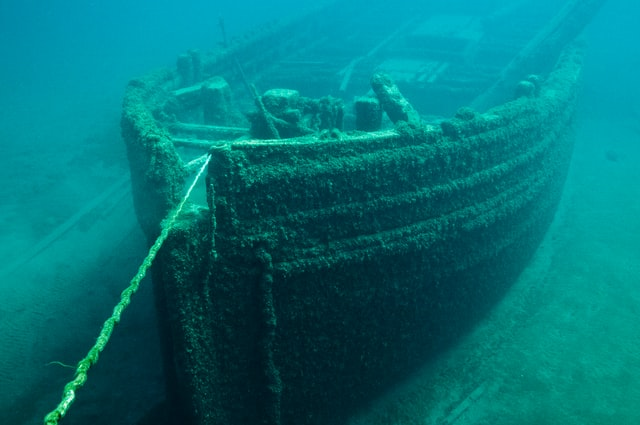

**Caption**: Can you predict which passengers will survive their ride on the Titanic? 🚣 🧊

In this exercise we will be attempting to predict whether or not a passenger on the titanic survived or not, based on their attributes (e.g., age, sex, passenger class, where they embarked, and so on). For this exercise, we will be relying on [Pandas](https://en.wikipedia.org/wiki/Pandas_(software)) [DataFrames](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html).

**Required (hints below):**

9. Calculate the mean of the age the corresponding standard deviation for the female and male populations in the passenger list. 

10. Set up a pipeline for the numerical attributes that implements an "median" imputer and a scaler 

11. Set up a pipeline for the categorical attributes that implements a "most frequent" imputer and a one-hot categorical encoder

12. Prepare the training and testing datasets for the Titanic data. What's the difference between `.fit_transform()` and `.transform()` ?

13. Train a random forest classifier with 100 estimators 

14. Make a prediction using the trained random forest classifier. How good is the accuracy? 

15. Compare this to a 10-fold cross validation mean.

16. Train a support-vector clustering algorithm and compare its 10-fold cross validation mean to that of the random forest classifier.

**Challenges:**

6. Choose two other models and try using them to predict whether or not a passenger would survive. Use grid-search to try out several hyperparameters and determine which model worked best out of the four.

7. Try converting numerical attributes to categorical attributes, such as age group instead of age, or those travelling alone vs with company.

Let's begin by fetching the data from the internet and loading it into memory:

In [ ]:
# Setup - We need to fetch the data from the internet
import os
import urllib.request

TITANIC_PATH = os.path.join(PROJECT_ROOT_DIR,"datasets", "titanic")
DOWNLOAD_URL = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/titanic/"

def fetch_titanic_data(url=DOWNLOAD_URL, path=TITANIC_PATH):
    if not os.path.isdir(path):
        os.makedirs(path)
    for filename in ("train.csv", "test.csv"):
        filepath = os.path.join(path, filename)
        if not os.path.isfile(filepath):
            print("Downloading", filename)
            urllib.request.urlretrieve(url + filename, filepath)

fetch_titanic_data()    

In [ ]:
# We further need to load the Titanic data into memory.

import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

# We will explicitely set the PassengerId attribute as the DataFrame index 
# since it is unique to each passenger
train_data = train_data.set_index("PassengerId")
test_data = test_data.set_index("PassengerId")

The data is already split into a training set and a test set. However, *the test data* does **not** contain the labels: your goal is to train the best model you can using the training data, then make your predictions on the test data.

Let's take a peek at the training set. Use the `.head()` method to return the first 5 rows of the training dataset. 

*If you're on colab, you can instead use Google's interactive data table!*

-----------------------

The dataset should include the following attributes:
* **PassengerId**: a unique identifier for each passenger
* **Survived**: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
* **Pclass**: passenger class.
* **Name**, **Sex**, **Age**: self-explanatory
* **SibSp**: how many siblings & spouses of the passenger aboard the Titanic.
* **Parch**: how many children & parents of the passenger aboard the Titanic.
* **Ticket**: ticket id
* **Fare**: price paid (in pounds)
* **Cabin**: passenger's cabin number
* **Embarked**: where the passenger embarked the Titanic. C=Cherbourg, Q=Queenstown, S=Southampton.

In [ ]:
# Load Google's data table to display the dataframe interactively
from google.colab import data_table
data_table.DataTable(train_data, num_rows_per_page=10)

Using DataFrames allow us to easily calculate statistics from the data. Here we will use the .median() and .std() methods to get an picture of the passenger population.

**Q9) Calculate the median and standard deviation for each listed sex category**

Hint: The "pre-filled" code below uses `pandas`' native [`median`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.median.html) and [`std`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.std.html) functions. If you prefer using [`Numpy`](https://numpy.org/doc/stable/index.html), `Numpy` also has functions for the median and the standard deviation. 

In [ ]:
# Complete the code
med_age_f = train_data[train_data["___"]=="___"]["___"].median()
stddev_age_f = 
med_age_m = 
stddev_age_m = 

print_out=(f'The female population had a median age of {med_age_f:.1f}'
           f' with a standard deviation of {stddev_age_f:.2f} \n'
           f'The male population had a median age of {med_age_m:.1f}'
           f' with a standard deviation of {stddev_age_m:.2f} \n')

print(print_out)


It's important that we be aware of the gaps in the data available. In order to do this, let's rely on the DataFrames `.info()` method:

In [ ]:
train_data.info()

Okay, the **Age**, **Cabin** and **Embarked** attributes are sometimes null (less than 891 non-null), especially the **Cabin** (77% are null). We will ignore the **Cabin** for now and focus on the rest. The **Age** attribute has about 19% null values, so we will need to decide what to do with them. One reasonable option is to replace null values with the median age. We could be a bit smarter by predicting the age based on the other columns (for example, the median age is 37 in 1st class, 29 in 2nd class and 24 in 3rd class), but we'll keep things simple and just use the overall median age. 

(Note: this will be done in a later step, when we develop the data pipeline)

The **Name** and **Ticket** attributes may have some value, but they will be a bit tricky to convert into useful numbers that a model can consume. So for now, we will ignore them.

Let's take a look at the numerical attributes:

In [ ]:
train_data.describe()

* Less than 50% of the passengers survived (About 38%, to be more precise). That's close enough to 40%, so accuracy will be a reasonable metric to evaluate our model.
* The mean **Fare** was £32.20, which does not seem so expensive, but the [Bank of England estimates](https://www.bankofengland.co.uk/monetary-policy/inflation/inflation-calculator) the value to be around _£3889_ in 2021.
* The mean **Age** was a little under 30 years old.
* Over half of the passengers were in 3rd Class 

We will now verify that the `Survived` class is indeed 0 or 1. 

We will also look at the types of values we have in our categorical variables, namely:  `Passenger Class`, `Sex`, and `Embarqued`.

Reminder: 
The Embarked attribute tells us where the passenger embarked: C=Cherbourg, Q=Queenstown, S=Southampton.

In [ ]:
print_out = ""
var_list = ["Survived", "Pclass", "Sex", "Embarked"]
for var in var_list: print_out += f'{train_data[var].value_counts()} \n\n'

print(print_out)

Now let's build our [data preprocessing pipelines](https://en.wikipedia.org/wiki/Data_pre-processing), starting with the pipeline for numerical attributes.
In this section we will set up a [Pipeline class](https://duckduckgo.com/?q=sklearn+pipeline), which will fill the missing values in the columns using the mean value (see the [SimpleImputer documentation](https://duckduckgo.com/?q=sklearn+simpleimputer)) and scale the data (see the [StandardScaler documentation](https://duckduckgo.com/?q=sklearn+standardscaler)).

**Q10) Set up the numerical attribute pipeline using a) an "imputer" that uses SimpleImputer with "median" set as the strategy and b) a "scaler" that uses a default StandardScaler**

Hint: The documentation for the `Pipeline` class is [at this link](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)

In [ ]:
# Complete the code
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# The Pipeline needs to be initiated with a list containing the name of the
# preprocessor (e.g., "imputer" or "scaler").
num_pipeline = Pipeline( [ ("", _________(_________="")),
                           ("", _________()) ] )

Now we can build the pipeline for the categorical attributes. Here, we will use [one-hot encoding](https://en.wikipedia.org/wiki/One-hot#Machine_learning_and_statistics) using the [OneHotEncoder](https://duckduckgo.com/?q=sklearn+onehotencoder) preprocessor in Scikit.


**Q11) Set up the categorical attribute pipeline using: a) an "imputer" that uses [`SimpleImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) with "most_frequent" set as the strategy and b) a "cat_encoder" that uses a [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) with the sparse parameter set to *`False`***

In [ ]:
# Complete the code
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline( [ ("", _________(_________="")),
                           ("", _________(_________="")) ] )

Finally, let's join the numerical and categorical pipelines using scikit's [ColumnTransformer](https://duckduckgo.com/?q=sklearn+ColumnTransformer):

In [ ]:
from sklearn.compose import ColumnTransformer

num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer( [("num", num_pipeline, num_attribs),
                                          ("cat", cat_pipeline, cat_attribs) ] )

We now have a preprocessing pipeline that takes the raw data and outputs numerical input features that we can feed to any Machine Learning model we want, and we can also generate the truth variable from the 'Survived' data.

Let's generate our train and test data.

--------------------
Note! We will continue using X_train, y_train, X_test, and y_test as the variable names for our training and testing datasets. However, the notebook only has one namespace. Thus, runnng the code below will overwrite the X_train/test and y_train/test variables from exercises 1 & 2. 

**Q12) Prepare the training and testing datasets.. What's the difference between `.fit_transform()` and `.transform()` ?**

Hint 1: Remember to load "Survived" into `y_train`!

Hint 2: Here are the documentation links for the [`transform`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline.transform) and [`fit_transform`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline.fit_transform) methods of the [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) class.

Hint 3: Because the dataset is from a Kaggle competition, there is no "Survived" category in the test set `test_data` to not give away the answer.

In [ ]:
# Complete the code
X_train = preprocess_pipeline.fit_transform(
              train_data[num_attribs + cat_attribs] )
X_test =  

y_train = 

#Let's print a sample to take a loot at the data being produced
for idx, attrib in np.ndenumerate(np.hstack((num_attribs,cat_attribs))):
    print(f"{attrib} has a value of {X_train[0][idx]}")

Now that we've finally prepared the pipeline, we can begin training algorithms!
Let's start by training a type of classifier called a [`RandomForestClassifier`](https://duckduckgo.com/?q=scikit+randomforestclassifie). This type of a classifier is an _ensemble classifier_, which employs a number of estimators that we have to define. Today, we will use 100 members in our ensemble.

**Q13) Import a RandomForestClassifier from scikit and instantiate it with 100 estimators. Then, fit the model**

Hint: The documentation for the `RandomForestClassifier` is [at this link](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [ ]:
# Complete the code
from sklearn._______ import ______

forest_clf = RandomForestClassifier(______, random_state=rnd_seed)
forest_clf.___(___,___)

Great, our model is trained! Let's use it to make predictions on the test set. Let's also check the accuracy of our model on the test dataset.

**Q14) Predict a set of answers using the trained model and compare it using the *accuracy_score* metric. Then, print out a statement reporting the accuracy**

*Hint 1: [Here's the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) for the `accuracy_score` metric*

*Hint 2: You don't have a set of labels for the test set (i.e., you don't have `y_test`), so you can't measure the accuracy using `X_test`. You do, however, have another dataset with both inputs `X` and labels `y`!*

*Hint 3: Though you won't be able to know if the model is over/underfitting the data if you measure the accuracy on the train set, it **will** give you an idea as to whether the model is able to make accurate predictions from the input data.*

In [ ]:
#Complete the code
y_pred =

from ____.___ import accuracy_score

print()

Our model gave us a prediction and we were able to compare how accurate our predictions were, but we're also interested in knowing how good our model is. 

And now we could just build a CSV file with these predictions (respecting the format excepted by Kaggle), then upload it and hope for the best. But wait! We can do better than hope. Why don't we use cross-validation to have an idea of how good our model is?

**Q15) Import the cross_val_score function and produce a set of 10-fold cross validation scores using the training data. Then, print the mean score. How does it compare with the answer to Q14?**

Hint: You may consult [the documentation of `cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

In [ ]:
# Complete the code
from ____.____ import cross_val_score

forest_scores = cross_val_score(__, __, __, __)

print(f'The mean score is {}')

We will now compare to the [leaderboard](https://www.kaggle.com/c/titanic/leaderboard) for the Titanic competition on Kaggle. How does our model compare?

Don't be discouraged by those with 100% accuracy - since you can easily find the [list of victims](https://www.encyclopedia-titanica.org/titanic-victims/) of the Titanic, it seems likely that there was little Machine Learning involved in their performance.

Let's move on from random forests and try an `SVC`, i.e., a [support-vector clustering algorithm](https://www.jmlr.org/papers/volume2/horn01a/horn01a.pdf).

**Q16) Train a support-vector clustering algorithm and generate a set of cross-validated scores**

Hint: Don't hesitate to recycle code from Q15!

In [ ]:
# Complete the code

# Let's import the SVC class and instantiate a model
from sklearn.svm import SVC
svm_clf = SVC(gamma="auto")

svm_scores = 
print(f'The mean score is {}')

If everything went well, this model should look better. Notice though that what we've printed so far is the mean score from the cross validation. While we do appreciate models having higher mean accuracy, consistency is also very important when making predictions! Let's visualize the scores using a box plot (Géron thanking Nevin Yilmaz as the proponents of this idea), where the points will represent the performance on the testing fold in each run. 

It's also important to note that the `boxplot()` function detects outliers (called "fliers") and does not include them within the whiskers. Specifically, if the lower quartile is  Q1  and the upper quartile is  Q3 , then the interquartile range  IQR=Q3−Q1  (this is the box's height), and any score lower than  Q1−1.5×IQR  is a flier, and so is any score greater than  Q3+1.5×IQR . 

But instead of just looking at the mean accuracy across the 10 cross-validation folds, let's plot all 10 scores for each model, along with a box plot highlighting the lower and upper quartiles, and "whiskers" showing the extent of the scores (thanks to Nevin Yilmaz for suggesting this visualization). Note that the `boxplot()` function detects outliers (called "fliers") and does not include them within the whiskers. Specifically, if the lower quartile is $Q_1$ and the upper quartile is $Q_3$, then the interquartile range $IQR = Q_3 - Q_1$ (this is the box's height), and any score lower than $Q_1 - 1.5 \times IQR$ is a flier, and so is any score greater than $Q3 + 1.5 \times IQR$.

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

If all goes as expected, the random forest classifier should have gotten a very high score on one of the 10 folds, but overall should have a lower mean score and a bigger spread. This suggests that the SVM classifier is more likely to generalize well.

## Challenges

* **C6)** Choose two other models and try using them to predict whether or not a passenger would survive. Use grid-search to try out several hyperparameters and determine which model worked best out of the four.

* **C7)** Try converting numerical attributes to categorical attributes, such as age group instead of age, or those travelling alone vs with company.